In [180]:
import os
import numpy
from matplotlib import pyplot as plt
import sys
import pandas as pd
import csv
from mpl_toolkits.mplot3d import Axes3D
import scipy as scipy
#sys.path.insert(0, r'/Users/nenetto/Dev/BiiGTK/src/PythonTools')
%matplotlib inline

In [181]:
def correctAngles(x,y,z):
    
    dvx = numpy.diff(x)
    dvx = numpy.concatenate(([0.0],dvx),0)
    thresholdx = numpy.median(dvx) + 5 * numpy.std(dvx)
    dvx = numpy.abs(dvx)
    
    dvy = numpy.diff(y)
    dvy = numpy.concatenate(([0.0],dvy),0)
    thresholdy = numpy.median(dvy) + 5 * numpy.std(dvy)
    dvy = numpy.abs(dvy)
    
    dvz = numpy.diff(z)
    dvz = numpy.concatenate(([0.0],dvz),0)
    thresholdz = numpy.median(dvz) + 5 * numpy.std(dvz)
    dvz = numpy.abs(dvz)
    

    threshold = numpy.max(numpy.array([thresholdx, thresholdy, thresholdz]))
    
    signx = 1
    signy = 1
    signz = 1
    
    
    cx = numpy.copy(x)
    cy = numpy.copy(y)
    cz = numpy.copy(z)
    
    
    for i in range(len(x)):
        
        if dvx[i] > threshold:
            signx = signx * (-1)
            
        if dvy[i] > threshold:
            signy = signz * (-1)
            
        if dvz[i] > threshold:
            signz = signz * (-1)
            
            
        if signx == (-1):
            cx[i] = x[i] + 360
            
        if signy == (-1):
            cy[i] = y[i] + 360
            
        if signz == (-1):
            cz[i] = z[i] + 360

    return cx,cy,cz

def addFakeBoundingBox(ax,X,Y,Z):
    # Create cubic bounding box to simulate equal aspect ratio
    max_range = numpy.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
    Xb = 0.5*max_range*numpy.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
    Yb = 0.5*max_range*numpy.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
    Zb = 0.5*max_range*numpy.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
    # Comment or uncomment following both lines to test the fake bounding box:
    for xb, yb, zb in zip(Xb, Yb, Zb):
       ax.plot([xb], [yb], [zb], 'w')

[-30.65567232 -30.29662556 -30.23265423 ..., -25.89952195 -27.88079052
 -28.64576897]


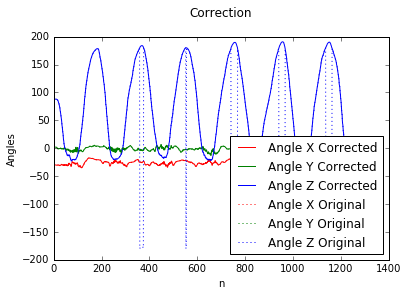

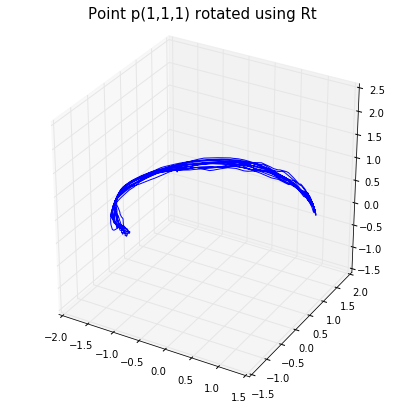

In [253]:
rotation_file = '/Users/nenetto/Trabajo/AlgiaCervical/DataTestInclinometro/movement_data.csv'

# Read by rows
import csv
csvfile = open(rotation_file, 'rb')
spamreader = csv.reader(csvfile, delimiter=',')

names = spamreader.next()
time = map(float, spamreader.next())
angleExtracted = spamreader.next()
xangle = map(float,spamreader.next())
yangle = map(float,spamreader.next())
zangle = map(float,spamreader.next())

# Number of points
time = numpy.array(time[::])
xangle = numpy.array(xangle[::])
yangle = numpy.array(yangle[::])
zangle = numpy.array(zangle[::])
N = len(time)
print xangle


# Correction of angles
cx, cy, cz = correctAngles(xangle,yangle,zangle)

# Data Matrix (Angles in columns)
A = numpy.zeros((N,3))
A[:,0] = cx
A[:,1] = cy
A[:,2] = cz


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(A[:,0],'r')
ax.plot(A[:,1],'g')
ax.plot(A[:,2],'b')
ax.plot(xangle,'r', ls = ':')
ax.plot(yangle,'g', ls = ':')
ax.plot(zangle,'b', ls = ':')
ax.legend(['Angle X Corrected',\
           'Angle Y Corrected',\
           'Angle Z Corrected',\
           'Angle X Original',\
           'Angle Y Original',\
           'Angle Z Original'], loc = 4)
ax.set_xlabel('n')
ax.set_ylabel('Angles')
ax.set_title('Correction\n')
plt.show()

# Build R(t) con los ángulos

Rt = numpy.zeros((3,3,N))
for i in range(N):
    # Get the angles from the data matrix A (Angles)
    x = numpy.deg2rad(A[i,0])
    y = numpy.deg2rad(A[i,1])
    z = numpy.deg2rad(A[i,2])
    
    #Build Rx, Ry, Rz
    
    Rx = numpy.eye(3)
    Ry = numpy.eye(3)
    Rz = numpy.eye(3)
    
    Rx[1,1] = numpy.cos(x)
    Rx[1,2] = -numpy.sin(x)
    Rx[2,1] = numpy.sin(x)
    Rx[2,2] = numpy.cos(x)
    
    Ry[0,0] = numpy.cos(y)
    Ry[0,2] = numpy.sin(y)
    Ry[2,0] = -numpy.sin(y)
    Ry[2,2] = numpy.cos(y)
    
    Rz[0,0] = numpy.cos(z)
    Rz[0,1] = -numpy.sin(z)
    Rz[1,0] = numpy.sin(z)
    Rz[1,1] = numpy.cos(z)
    
    Rt_i = numpy.dot(Rz,numpy.dot(Ry,Rx))

    Rt[:,:,i] = Rt_i
    
   
# p = [1,1,1]
p = numpy.array([1.0,1.0,1.0])

# Rotate p using Rt
Pt = numpy.zeros((N,3))
for i in range(N):
    Pt[i,:] = numpy.dot(Rt[:,:,i],p)
    


    
# Draw results of p moved

X = Pt[:,0]
Y = Pt[:,1]
Z = Pt[:,2]

import mpl_toolkits.mplot3d

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')

ax1.plot(X,Y,Z, color = 'b', lw = '1.0')
addFakeBoundingBox(ax1,X,Y,Z) # Axis Equal
ax1.set_title('Point p(1,1,1) rotated using Rt\n', fontsize=15);
    


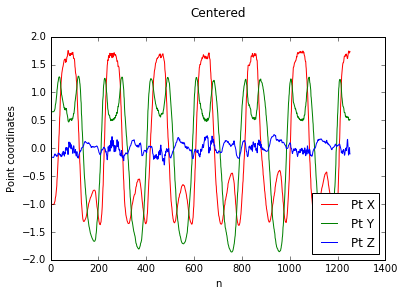

CovMatrix  (3, 3)
U
[[-0.75919824  0.65073322 -0.0128185 ]
 [-0.65033389 -0.75764674  0.05511124]
 [ 0.02615082  0.05017666  0.99839794]]
Vt
[[-0.75919824 -0.65033389  0.02615082]
 [ 0.65073322 -0.75764674  0.05017666]
 [-0.0128185   0.05511124  0.99839794]]
S
[ 2435.06466646   674.37087293     8.66694454]
Cov
[[ 1689.09364206   869.78175581   -26.43654927]
 [  869.78175581  1417.006527     -66.57269535]
 [  -26.43654927   -66.57269535    12.00231487]]
SVD product
[[ 1689.09364206   869.78175581   -26.43654927]
 [  869.78175581  1417.006527     -66.57269535]
 [  -26.43654927   -66.57269535    12.00231487]]
R * Rt
[[  1.00000000e+00  -3.81639165e-17   6.93889390e-18]
 [ -3.81639165e-17   1.00000000e+00   6.93889390e-18]
 [  6.93889390e-18   6.93889390e-18   1.00000000e+00]]
Center:  -0.474981939279 0.0827916542444
Radius: 1.64337356987


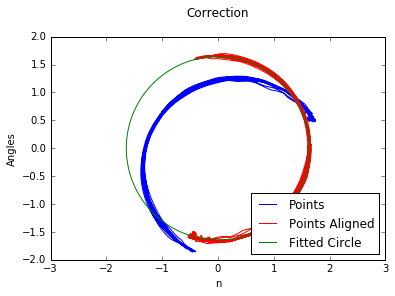

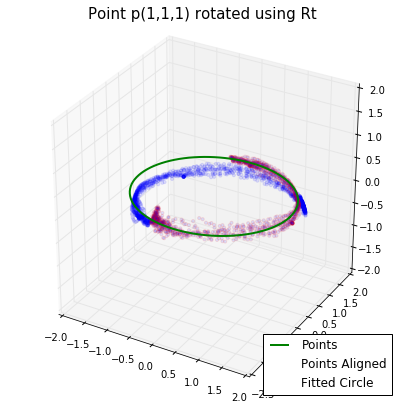

In [278]:
# Creation of X (Matriz de Covarianza)

## Resto el centroide de los datos
Ptmean = numpy.mean(Pt,axis = 0)

Ptcentered = Pt.copy()
for i in range(N):
    Ptcentered[i,:] -= Ptmean

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Ptcentered[:,0],'r')
ax.plot(Ptcentered[:,1],'g')
ax.plot(Ptcentered[:,2],'b')
ax.legend(['Pt X',\
           'Pt Y',\
           'Pt Z'], loc = 4)
ax.set_xlabel('n')
ax.set_ylabel('Point coordinates')
ax.set_title('Centered\n')
plt.show()

# Covariance
CovMatrix = numpy.dot(Ptcentered.T,Ptcentered)
print "CovMatrix ", CovMatrix.shape


# SVD
U, S, Vt = numpy.linalg.svd(CovMatrix, full_matrices = True)
print "U"
print U
print "Vt"
print Vt
print "S"
print S

print "Cov"
print CovMatrix
print "SVD product"
print numpy.dot(U,numpy.dot(numpy.diag(S),Vt))

# Matriz de Rotación de ejes A(plano donde quiero las medidas) -> B(Plano donde tomo las medidas)
R = Vt

# Comprobaciones
print "R * Rt"
print numpy.dot(R,R.T)

Rinverted = R.T.copy()


# Transform points 
PtcenteredRotatedBack = Ptcentered.copy()
PtcenteredRotatedBack = numpy.dot(Rinverted,Ptcentered.T).T 


# Ajustar a una circunferencia
from scipy.optimize import minimize
xv = PtcenteredRotatedBack[:,0]
yv = PtcenteredRotatedBack[:,1]


from scipy import  odr
def circfit(xs, ys):
    def fitEllipse(x,y):
        x = x[:,numpy.newaxis]
        y = y[:,numpy.newaxis]
        D =  numpy.hstack((x*x, x*y, y*y, x, y, numpy.ones_like(x)))
        S = numpy.dot(D.T,D)
        C = numpy.zeros([6,6])
        C[0,2] = C[2,0] = 2; C[1,1] = -1
        E, V =  numpy.linalg.eig(numpy.dot(numpy.linalg.inv(S), C))
        n = numpy.argmax(numpy.abs(E))
        a = V[:,n]
        return a
    
    def ellipse_center(a):
        b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
        num = b*b-a*c
        x0=(c*d-b*f)/num
        y0=(a*f-b*d)/num
        return numpy.array([x0,y0])

    def ellipse_axis_length( a ):
        b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
        up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
        down1=(b*b-a*c)*( (c-a)*numpy.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
        down2=(b*b-a*c)*( (a-c)*numpy.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
        res1=numpy.sqrt(up/down1)
        res2=numpy.sqrt(up/down2)
        return numpy.array([res1, res2])
    

    a = fitEllipse(xs,ys)
    xc_3, yc_3 = ellipse_center(a)
    
    R = ellipse_axis_length( a )
    
    R_3 = numpy.mean(R)
    return xc_3, yc_3, R_3

xc, yc, r = circfit(xv,yv)
print "Center: ", xc, yc
print "Radius:", r


def createCircle(alphaN, cx,cy,r):

    circle = numpy.zeros((3,alphaN))
    alphaVector = numpy.linspace(0,2 * numpy.pi, alphaN)

    for i in range(alphaN):
        circle[0,i] = cx + r * numpy.cos(alphaVector[i])
        circle[1,i] = cy + r * numpy.sin(alphaVector[i])
        circle[2,i] = 0.0

    return circle.T

circle = createCircle(100, 0.0,0.0,r)


# Center the points in (0,0,0)
# Recentered
for i in range(N):
    PtcenteredRotatedBack[i,:] -= numpy.array([xc,yc,0.0])



fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Ptcentered[:,0],Ptcentered[:,1],'b')
ax.plot(PtcenteredRotatedBack[:,0],PtcenteredRotatedBack[:,1],'r')
ax.plot(circle[:,0],circle[:,1],'g')
ax.legend(['Points','Points Aligned', 'Fitted Circle'], loc = 4)
ax.axis('equal')
ax.set_xlabel('n')
ax.set_ylabel('Angles')
ax.set_title('Correction\n')
plt.show()





# Print rotated data

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(Ptcentered[:,0],Ptcentered[:,1],Ptcentered[:,2], facecolors='none',\
                    edgecolors='b',marker='o',s=10, alpha = 0.1)
ax1.scatter(PtcenteredRotatedBack[:,0],PtcenteredRotatedBack[:,1],PtcenteredRotatedBack[:,2], facecolors='none',\
                    edgecolors='r',marker='o',s=10, alpha = 0.1)
ax1.plot(circle[:,0],circle[:,1],0.0, color = 'g', lw = '2.0')
addFakeBoundingBox(ax1,Ptcentered[:,0],Ptcentered[:,1],Ptcentered[:,2]) # Axis Equal
ax1.legend(['Points','Points Aligned', 'Fitted Circle'], loc = 4)
ax1.set_title('Point p(1,1,1) rotated using Rt\n', fontsize=15);







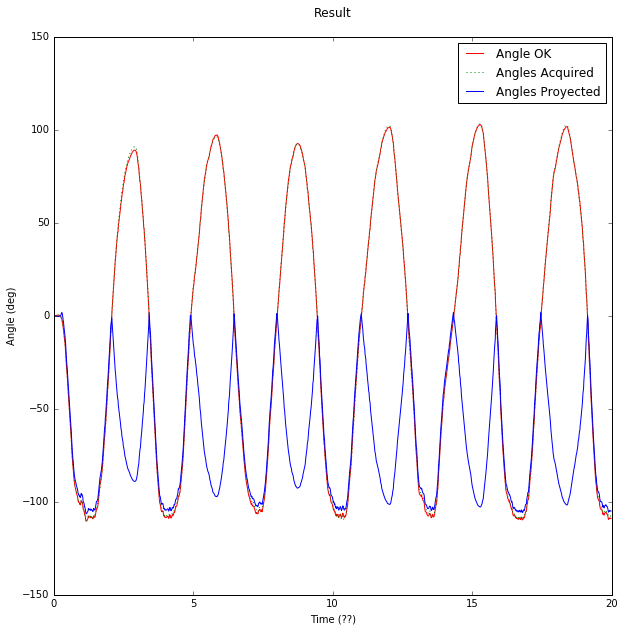

Rinverted
[[-0.75919824  0.65073322 -0.0128185 ]
 [-0.65033389 -0.75764674  0.05511124]
 [ 0.02615082  0.05017666  0.99839794]]
Range: 213.161304276


In [265]:
xunitary = numpy.array([1.0,0.0,0.0])
yunitary = numpy.array([0.0,1.0,0.0])

Pt2 = PtcenteredRotatedBack.copy()
Pt2[:,2] = 0.0 * Pt2[:,2]


modulesPt = numpy.zeros((N,1))
for i in range(N):
    modulesPt[i] = numpy.linalg.norm(Pt2[i,:])
    
angleFinalX = numpy.zeros((N,1))
angleProyected = numpy.zeros((N,1))

for i in range(N):
    angleProyected[i] = numpy.rad2deg(numpy.arccos(numpy.dot(xunitary,Pt2[i,:])/modulesPt[i]))
    if Pt2[i,0]>0 and Pt2[i,1]>0: # x>0 & y>0 Nada
        angleFinalX[i] = -numpy.rad2deg(numpy.arccos(numpy.dot(xunitary,Pt2[i,:])/modulesPt[i]))
    elif Pt2[i,0]>0 and Pt2[i,1]<0: # x>0 & y<0
        angleFinalX[i] = numpy.rad2deg(numpy.arccos(numpy.dot(xunitary,Pt2[i,:])/modulesPt[i]))
    elif Pt2[i,0]<0 and Pt2[i,1]>0: # x<0 & y>0
        angleFinalX[i] = -numpy.rad2deg(numpy.arccos(numpy.dot(xunitary,Pt2[i,:])/modulesPt[i]))
    else:
        angleFinalX[i] = numpy.rad2deg(numpy.arccos(numpy.dot(xunitary,Pt2[i,:])/modulesPt[i]))

angleFinalX = -angleFinalX + angleFinalX[0] 
angleProyected = -angleProyected + angleProyected[0]



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(time, angleFinalX,'r')
ax.plot(time, A[:,2]- A[0,2],'g',ls = ':')
ax.plot(time, angleProyected, 'b')
ax.legend(['Angle OK', 'Angles Acquired', 'Angles Proyected'])
ax.set_xlabel('Time (??)')
ax.set_ylabel('Angle (deg)')
ax.set_title('Result\n')
plt.show()

print "Rinverted"
print Rinverted

print "Range:", numpy.max(angleFinalX) - numpy.min(angleFinalX)
    

601.5


[ True False False]


In [74]:
print "hola 0"

hola 0


In [75]:
print "Hola"

Hola
